Реализуем Алгоритм Метрополиса — Гастингса

In [3]:
# %load mcmc_sampler.py
import numpy
from scipy import stats


class MCMCSampler:
    def __init__(self, target_pdf):
        self.target_pdf = target_pdf
        self.uniform = stats.uniform()

    def sample(self, x_0, sample_from_proposal_fun, n_samples):
        x_prev = x_0
        result = [x_prev]
        for i in range(0, n_samples):
            proposed_x = sample_from_proposal_fun(x_prev)
            acceptance_probability = min(self.target_pdf(proposed_x) / self.target_pdf(x_prev), 1)
            if acceptance_probability >= self.uniform.rvs():
                x_prev = proposed_x
            result.append(x_prev)
        return numpy.array(result)


Определим:
- PDF и CDF распределения из которого будем генерировать семплы. Будем рассматривать смесь двух нормальных.
- функцию для создания вспомогательных распределений `create_sample_from_random_walk_proposal_fun`
- размер семпла
- функцию семплирования и визуализации $D_n$ статистики


In [4]:
# %load mcmc.py
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.ndimage.filters import gaussian_filter1d

import tests
from mcmc_sampler import MCMCSampler

multivariate_normal1 = stats.multivariate_normal([0], [[0.5]])
multivariate_normal2 = stats.multivariate_normal([-4], [[0.5]])


def pdf(x): return 0.4 * multivariate_normal1.pdf(x) + 0.6 * multivariate_normal2.pdf(x)


def cdf(x): return 0.4 * multivariate_normal1.cdf(x) + 0.6 * multivariate_normal2.cdf(x)


def create_sample_from_random_walk_proposal_fun(D):
    normal = stats.multivariate_normal([0], [[D]])
    return lambda x: normal.rvs() + x


sample_size = 10000
sampler = MCMCSampler(pdf)


def sample_and_plot(ds):
    samples = []
    for d in ds:
        sample = sampler.sample(0, create_sample_from_random_walk_proposal_fun(d), sample_size)
        samples.append(sample)

    plt.yscale("log")
    plt.xscale("log")
    plt.xlabel("n")
    plt.ylabel("D_n")

    ks_test_points = range(sample_size)
    for index, sample in enumerate(samples):
        dn = tests.kstest(sample, cdf, ks_test_points)
        smooth_dn = gaussian_filter1d(dn, sigma=50)
        plt.plot(ks_test_points, smooth_dn, label=str(ds[index]))
        plt.legend(loc='best')
    plt.show()

Попробуем найти подходящее значение дисперсии вспомогательного распределения.
Сначала найдем подходящий порядок.

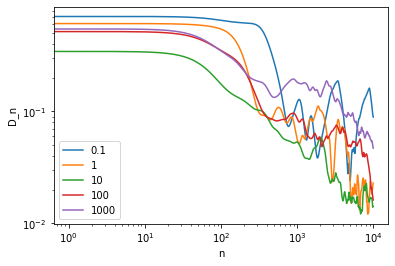

In [5]:
sample_and_plot([0.1, 1, 10, 100, 1000])

Угол наклона графика с логарифмическми шкалами позволяет оценить скорость сходимости.
0.1 и 1000 хуже других.  
Попробуем некоторые значения из $[1,100]$

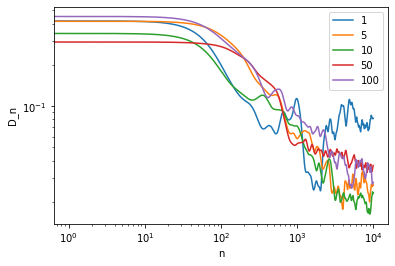

In [6]:
sample_and_plot([1, 5, 10, 50, 100])

1,50,100 хуже других.
Попробуем некоторые значения из $[5,50]$

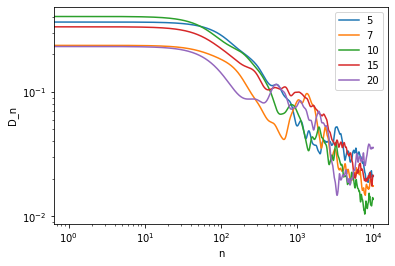

In [9]:
sample_and_plot([5, 7, 10, 15, 20])

20,15,5 хуже других.
Попробуем некоторые значения из $(5,15)$

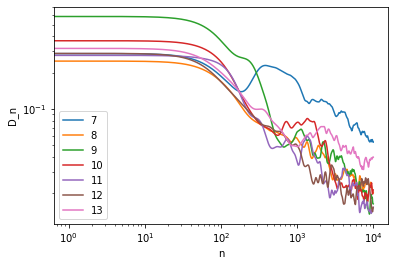

In [10]:
sample_and_plot([7, 8, 9, 10, 11, 12, 13])

7 и 13 хуже других.\
Наклон графиков для $[8,12]$ визуально не отличим.\
В качестве вспомогательного распределения хорошо использовать $\mathcal {N}(0,D)$,где $D \in [8,12]$